# Intro

## Packages

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, make_scorer, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from scipy.stats import loguniform, uniform, randint 
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


## Data-frame 

In [71]:
df = pd.read_csv("features.csv", sep=";")
df

df["Label"].value_counts()

Label
objective     635
subjective    365
Name: count, dtype: int64

## Nettoyage de la base 

In [72]:
df = df.drop('semanticobjscore', axis=1) 
df = df.drop('semanticsubjscore', axis=1) 
df = df.drop('TextID', axis=1) 
df = df.drop('URL', axis=1) 

df

,Label,totalWordsCount,CC,CD,DT,EX,FW,INs,JJ,JJR,...,pronouns2nd,pronouns3rd,compsupadjadv,past,imperative,present3rd,present1st2nd,sentence1st,sentencelast,txtcomplexity
0,objective,109,7,9,0,5,8,6,0,0,...,0,3,0,11,0,0,0,0,1,18
1,objective,309,1,19,1,4,35,23,0,0,...,0,10,0,13,0,14,9,1,1,14
2,objective,149,8,14,0,5,15,11,0,0,...,0,2,0,8,0,3,2,1,1,18
3,objective,305,7,26,0,10,37,21,1,1,...,0,8,3,13,1,7,1,1,1,20
4,objective,491,33,47,0,12,61,36,0,1,...,0,16,2,34,1,5,6,1,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,subjective,926,5,83,1,20,96,63,1,4,...,16,46,10,13,12,49,29,1,1,24
996,subjective,876,9,109,1,16,89,49,2,1,...,8,43,5,34,9,19,31,1,1,21
997,subjective,1469,14,171,1,10,157,106,5,6,...,9,49,12,40,19,51,42,1,1,18
998,subjective,343,4,24,0,9,28,20,0,0,...,0,8,1,3,3,25,7,1,1,11


On supprime les scores d'objectivité et de subjectivité qui informent trop notre modèle et rendent presque caduc la suite du projet. 

In [73]:
X = df.drop('Label', axis=1) 
y = df['Label'] 

#Séparation train / test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(
   X, y,
    test_size=0.2,     
    random_state=3,   
   shuffle=True,       
   stratify= y       # Pour pallier le déséquilibre entre les deux catégories de y 
)

print("Train :", X_train.shape)
print("Test  :", X_test.shape)
y_train.value_counts()

Train : (800, 57)
Test  : (200, 57)


Label
objective     508
subjective    292
Name: count, dtype: int64

# Premier modèle : la régression logistique 

Pour la régression logistique, on redécoupe la base d'entraînement en base d'entraînement et de validation. Cette dernière sert à tester notre modèle avec plusieurs hyperparamètres distincts 

In [74]:
y_train_lr = y_train.map({'objective': 1, 'subjective': 0}).astype(float)
y_test_lr = y_test.map({'objective': 1, 'subjective': 0}).astype(float)

print("Correspondance des classes :")
print("1 = objective, 0 = subjective")
print(y_train_lr.value_counts())

# 2. Créer un validation set à partir du train (pas du test!)
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(
    X_train, y_train_lr,  
    test_size=0.25,  
    random_state=3,
    stratify=y_train_lr
)

print("\nRégression Logistique - Shapes:")
print("Train :", X_train_lr.shape)
print("Val   :", X_val_lr.shape)
print("Test  :", X_test.shape) 




Correspondance des classes :
1 = objective, 0 = subjective
Label
1.0    508
0.0    292
Name: count, dtype: int64

Régression Logistique - Shapes:
Train : (600, 57)
Val   : (200, 57)
Test  : (200, 57)


On cherche à mener la régression logistique avec le meilleur paramètre C (inverse de la régularisation) possible, pour cela on en teste plusieurs sur la base de validation 

In [75]:

# On normalise les données 
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_val_lr_scaled = scaler.transform(X_val_lr) 
X_test_scaled = scaler.transform(X_test)

# Hyperparamètre à tester
C_VALUES = [0.01, 0.1, 1, 10, 100]

best_C = None
best_val_score = -1.0
best_model = None

for C_val in C_VALUES:
    print(f"Test du modèle avec C = {C_val} ")
    
    # Création et Entraînement
    model = LogisticRegression(random_state=3, max_iter=1000, C=C_val)
    model.fit(X_train_lr_scaled, y_train_lr)     
    
    y_pred_train = model.predict(X_train_lr_scaled)
    train_accuracy = accuracy_score(y_train_lr, y_pred_train)
    train_precision = precision_score(y_train_lr, y_pred_train)
    train_recall = recall_score(y_train_lr, y_pred_train)
    train_f1 = f1_score(y_train_lr, y_pred_train)

    y_pred_val = model.predict(X_val_lr_scaled)
    val_accuracy = accuracy_score(y_val_lr, y_pred_val)
    val_precision = precision_score(y_val_lr, y_pred_val)
    val_recall = recall_score(y_val_lr, y_pred_val)
    val_f1 = f1_score(y_val_lr, y_pred_val)
    
     
    print(f"Train Precision: {train_precision:.4f}")
    print(f"Validation Precision: {val_precision:.4f}")
    print("\n")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Train Recall: {train_recall:.4f}")
    print(f"Validation Recall: {val_recall:.4f}")
    print(f"Train F1: {train_f1:.4f}")
    print(f"Validation F1-score: {val_f1:.4f}")
    print("\n") 


    if val_precision > best_val_score:
        best_val_score = val_precision
        best_C = C_val
        best_model = model 
        
    

print(f"On sélectionne le paramètre C = {best_C}")
print(f"Meilleur score de validation (précision): {best_val_score:.4f}")




Test du modèle avec C = 0.01 
Train Precision: 0.8397
Validation Precision: 0.8357


Train Accuracy: 0.8383
Validation Accuracy: 0.8350
Train Recall: 0.9213
Validation Recall: 0.9213
Train F1: 0.8786
Validation F1-score: 0.8764


Test du modèle avec C = 0.1 
Train Precision: 0.8627
Validation Precision: 0.8540


Train Accuracy: 0.8583
Validation Accuracy: 0.8500
Train Recall: 0.9239
Validation Recall: 0.9213
Train F1: 0.8923
Validation F1-score: 0.8864


Test du modèle avec C = 1 
Train Precision: 0.8716
Validation Precision: 0.8417


Train Accuracy: 0.8667
Validation Accuracy: 0.8400
Train Recall: 0.9265
Validation Recall: 0.9213
Train F1: 0.8982
Validation F1-score: 0.8797


Test du modèle avec C = 10 
Train Precision: 0.8759
Validation Precision: 0.8298


Train Accuracy: 0.8700
Validation Accuracy: 0.8300
Train Recall: 0.9265
Validation Recall: 0.9213
Train F1: 0.9005
Validation F1-score: 0.8731


Test du modèle avec C = 100 
Train Precision: 0.8695
Validation Precision: 0.8286


Tr

Augmenter C (réduire la pénalisation) creuse l'écart entre le score de précision sur l'ensemble d'entraînement et celui de validation. Autrement dit, cela génère un surapprentissage important. De plus, le score de précision de l'ensemble de validation augmente lorsque C passe de 0.01 à 0.1 puis diminue ensuite. On choisit donc C = 0.1 

In [76]:
model = LogisticRegression(random_state=3, max_iter=1000, C =0.1)

model.fit(X_train_lr_scaled, y_train_lr)

y_pred_train = model.predict(X_train_lr_scaled)
y_pred_test = model.predict(X_test_scaled)

print("Test accuracy:", accuracy_score(y_test_lr, y_pred_test))
print("Test precision:", precision_score(y_test_lr, y_pred_test))
print("Test recall:", recall_score(y_test_lr, y_pred_test))
print("Test F1:", f1_score(y_test_lr, y_pred_test))



Test accuracy: 0.825
Test precision: 0.823943661971831
Test recall: 0.9212598425196851
Test F1: 0.8698884758364313


# Random Forest

In [89]:
# On modifie le dataset pour que chaque colonne soit maintenant binaire. Les différentes valeurs d'une variables sont toutes en colonnes. 

# Liste de toutes les colonnes à encoder
categorical_features = X_train.columns.tolist()

# Créer le transformateur
# handle_unknown='ignore' permet de gérer des catégories qui n'apparaissent que dans le test
preprocessor = ColumnTransformer( #permet d’appliquer l’One-Hot Encoder à toutes les colonnes catégorielles en une seule fois.
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Appliquer l'encodage sur le train
X_train_encoded = preprocessor.fit_transform(X_train)

# Appliquer le même encodage sur le test
X_test_encoded = preprocessor.transform(X_test)

# Vérifier la forme
print("Shape X_train_encoded :", X_train_encoded.shape)
print("Shape X_test_encoded  :", X_test_encoded.shape)

X_train_encoded

Shape X_train_encoded : (800, 3501)
Shape X_test_encoded  : (200, 3501)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(800, 3501))

In [78]:
precision_objective = make_scorer(
    precision_score,
    pos_label='objective',
    zero_division=0
)


# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [ 50, 100, 150, 200, 250, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10, 15, 20]
}

# Modèle
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,                      # ← 3 folds
    scoring= precision_objective,        # on veut optimiser la precision pour le label 'objective'
    n_jobs=-1,                 # utilise tous les CPU
    verbose=1                  # affiche la progression
)

# Entraînement (avec validation croisée intégrée)
grid.fit(X_train_encoded, y_train)


Fitting 3 folds for each of 90 candidates, totalling 270 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [5, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [50, 100, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(p...ro_division=0)
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",3
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter can

In [79]:
print("Meilleurs hyperparamètres :", grid.best_params_)
print("Score moyen validation :", grid.best_score_)

Meilleurs hyperparamètres : {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Score moyen validation : 0.8536057507832542


In [80]:
y_pred = grid.best_estimator_.predict(X_test_encoded)
test_precision = precision_score(
    y_test,
    y_pred,
    pos_label='objective',
    zero_division=0
)

print("Précision sur la base de test :", test_precision)



Précision sur la base de test : 0.813953488372093


# Réseau de neurone

In [81]:

y_train_nn = y_train.map({'objective': 1, 'subjective': 0}).astype(float)
y_test_nn = y_test.map({'objective': 1, 'subjective': 0}).astype(float)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [82]:

model_base = MLPClassifier(max_iter=2000, random_state=3)


# On définit l'ensemble des hyperparamètres à tester 
param_dist = {
    # hidden_layer_sizes
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50), (128, 64)], 
    
    # Régularisation 
    'alpha': loguniform(1e-4, 1e-0), 
    
    # Optimisation (learning_rate_init) 
    'learning_rate_init': loguniform(1e-5, 1e-1), # On utilise log pour augmenter le poids accordé aux valeurs entre 0.000001 et 0.1
    # Fonction d'activation 
    'activation': ['tanh', 'relu'],
    
    # Type de solveur 
    'solver': ['adam', 'sgd'] 
}



random_search = RandomizedSearchCV(
    estimator=model_base,
    param_distributions=param_dist,
    n_iter=50, 
    scoring='precision', 
    cv=5, 
    random_state=3, 
    verbose=2,
    n_jobs=-1 
)

print("Début de la recherche aléatoire")
random_search.fit(X_train_scaled, y_train_nn) 
print("Recherche aléatoire terminée.")


# Récupération du meilleur jeu d'hyperparamètres 
best_params = random_search.best_params_

# Récupération du modèle qui a obtenu le meilleur score de validation croisée
best_model = random_search.best_estimator_


print("Meilleurs hyperparamètres : :")
print(best_params)
print(f"Meilleur score de validation croisée (Score de précision) : {random_search.best_score_:.4f}")

# Évaluation finale sur l'ensemble de TEST
y_pred_test = best_model.predict(X_test_scaled)

test_precision = precision_score(y_test_nn, y_pred_test)
print(f"Performance finale sur la base de TEST : Score de précision = {test_precision:.4f}")

print("\nTableau de bord de performance :")
print("Test accuracy:", accuracy_score(y_test_nn, y_pred_test))
print("Test precision:", precision_score(y_test_nn, y_pred_test))
print("Test recall:", recall_score(y_test_nn, y_pred_test))
print("Test F1:", f1_score(y_test_nn, y_pred_test))




Début de la recherche aléatoire
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END activation=relu, alpha=0.3730678440610188, hidden_layer_sizes=(50, 25), learning_rate_init=1.1884804293088614e-05, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.3730678440610188, hidden_layer_sizes=(50, 25), learning_rate_init=1.1884804293088614e-05, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.3730678440610188, hidden_layer_sizes=(50, 25), learning_rate_init=1.1884804293088614e-05, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.3730678440610188, hidden_layer_sizes=(50, 25), learning_rate_init=1.1884804293088614e-05, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.3730678440610188, hidden_layer_sizes=(50, 25), learning_rate_init=1.1884804293088614e-05, solver=sgd; total time=   2.5s
[CV] END activation=tanh, alpha=0.0009807384199410206, hidden_layer_sizes=(50,), learning_rate_init=0.00601581692082581, solver=sgd; total time=   2.8s
[CV] END activation=tanh, alpha=0.02309145345015643, hidden_layer_sizes=(

/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.004068577323866061, hidden_layer_sizes=(100,), learning_rate_init=0.0001361759228380247, solver=adam; total time=   6.9s
[CV] END activation=tanh, alpha=0.04108124626070775, hidden_layer_sizes=(100,), learning_rate_init=1.2372864738043332e-05, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.04108124626070775, hidden_layer_sizes=(100,), learning_rate_init=1.2372864738043332e-05, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.04108124626070775, hidden_layer_sizes=(100,), learning_rate_init=1.2372864738043332e-05, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.04108124626070775, hidden_layer_sizes=(100,), learning_rate_init=1.2372864738043332e-05, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.17207461841953198, hidden_layer_sizes=(128, 64), learning_rate_init=0.000325069456632544, solver=adam; total time=   2.7s
[CV] END activation=tanh, alpha=0.17207461841953198, hidden_layer_sizes=(

/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.5565889749107682, hidden_layer_sizes=(128, 64), learning_rate_init=3.7227966704999966e-05, solver=adam; total time=  12.2s
[CV] END activation=tanh, alpha=0.0006250346661557744, hidden_layer_sizes=(50, 25), learning_rate_init=2.5143016381118958e-05, solver=adam; total time=   2.7s
[CV] END activation=relu, alpha=0.5565889749107682, hidden_layer_sizes=(128, 64), learning_rate_init=3.7227966704999966e-05, solver=adam; total time=  12.4s
[CV] END activation=relu, alpha=0.01633469114296742, hidden_layer_sizes=(100, 50), learning_rate_init=2.2080193309853895e-05, solver=sgd; total time=   2.6s


/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.5565889749107682, hidden_layer_sizes=(128, 64), learning_rate_init=3.7227966704999966e-05, solver=adam; total time=  12.1s
[CV] END activation=relu, alpha=0.01633469114296742, hidden_layer_sizes=(100, 50), learning_rate_init=2.2080193309853895e-05, solver=sgd; total time=   3.0s
[CV] END activation=relu, alpha=0.5565889749107682, hidden_layer_sizes=(128, 64), learning_rate_init=3.7227966704999966e-05, solver=adam; total time=  12.8s
[CV] END activation=relu, alpha=0.01633469114296742, hidden_layer_sizes=(100, 50), learning_rate_init=2.2080193309853895e-05, solver=sgd; total time=   3.1s


/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.01633469114296742, hidden_layer_sizes=(100, 50), learning_rate_init=2.2080193309853895e-05, solver=sgd; total time=   3.1s
[CV] END activation=relu, alpha=0.01633469114296742, hidden_layer_sizes=(100, 50), learning_rate_init=2.2080193309853895e-05, solver=sgd; total time=   3.1s
[CV] END activation=tanh, alpha=0.0020810639294043276, hidden_layer_sizes=(100,), learning_rate_init=0.0012718737527208834, solver=adam; total time=   1.8s
[CV] END activation=relu, alpha=0.5565889749107682, hidden_layer_sizes=(128, 64), learning_rate_init=3.7227966704999966e-05, solver=adam; total time=  12.8s
[CV] END activation=tanh, alpha=0.0020810639294043276, hidden_layer_sizes=(100,), learning_rate_init=0.0012718737527208834, solver=adam; total time=   1.7s


/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0020810639294043276, hidden_layer_sizes=(100,), learning_rate_init=0.0012718737527208834, solver=adam; total time=   1.9s
[CV] END activation=tanh, alpha=0.0020810639294043276, hidden_layer_sizes=(100,), learning_rate_init=0.0012718737527208834, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.0020810639294043276, hidden_layer_sizes=(100,), learning_rate_init=0.0012718737527208834, solver=adam; total time=   1.8s
[CV] END activation=tanh, alpha=0.23356767814028892, hidden_layer_sizes=(50,), learning_rate_init=0.012329763337575956, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.23356767814028892, hidden_layer_sizes=(50,), learning_rate_init=0.012329763337575956, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.23356767814028892, hidden_layer_sizes=(50,), learning_rate_init=0.012329763337575956, solver=sgd; total time=   1.8s
[CV] END activation=tanh, alpha=0.23356767814028892, hidden_layer_sizes=(50,), 

/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.6813102700640399, hidden_layer_sizes=(128, 64), learning_rate_init=5.662437283389554e-05, solver=adam; total time=  11.4s
[CV] END activation=tanh, alpha=0.0017011198402837671, hidden_layer_sizes=(100,), learning_rate_init=0.047801516120269984, solver=adam; total time=   0.3s
[CV] END activation=tanh, alpha=0.0017011198402837671, hidden_layer_sizes=(100,), learning_rate_init=0.047801516120269984, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.0014571014263368891, hidden_layer_sizes=(128, 64), learning_rate_init=0.02459732059158962, solver=adam; total time=   0.6s
[CV] END activation=tanh, alpha=0.0017011198402837671, hidden_layer_sizes=(100,), learning_rate_init=0.047801516120269984, solver=adam; total time=   0.4s
[CV] END activation=tanh, alpha=0.06756565957747941, hidden_layer_sizes=(100,), learning_rate_init=1.8142318707595068e-05, solver=sgd; total time=   1.5s
[CV] END activation=tanh, alpha=0.06756565957747941, hidden_layer_si

/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.6813102700640399, hidden_layer_sizes=(128, 64), learning_rate_init=5.662437283389554e-05, solver=adam; total time=  12.3s
[CV] END activation=relu, alpha=0.6813102700640399, hidden_layer_sizes=(128, 64), learning_rate_init=5.662437283389554e-05, solver=adam; total time=  12.1s
[CV] END activation=tanh, alpha=0.32273655269212315, hidden_layer_sizes=(100,), learning_rate_init=0.03315119293715507, solver=sgd; total time=   0.9s
[CV] END activation=relu, alpha=0.6813102700640399, hidden_layer_sizes=(128, 64), learning_rate_init=5.662437283389554e-05, solver=adam; total time=  12.3s


/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.32273655269212315, hidden_layer_sizes=(100,), learning_rate_init=0.03315119293715507, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.32273655269212315, hidden_layer_sizes=(100,), learning_rate_init=0.03315119293715507, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.32273655269212315, hidden_layer_sizes=(100,), learning_rate_init=0.03315119293715507, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.32273655269212315, hidden_layer_sizes=(100,), learning_rate_init=0.03315119293715507, solver=sgd; total time=   1.3s
[CV] END activation=tanh, alpha=0.7700114591702354, hidden_layer_sizes=(100,), learning_rate_init=6.603270307144708e-05, solver=adam; total time=   2.9s
[CV] END activation=tanh, alpha=0.004203353614634955, hidden_layer_sizes=(50, 25), learning_rate_init=0.00018000163956162775, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.7700114591702354, hidden_layer_sizes=(100,), learni

/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.20485718737070294, hidden_layer_sizes=(128, 64), learning_rate_init=2.6526925190445296e-05, solver=adam; total time=  11.6s
[CV] END activation=relu, alpha=0.20485718737070294, hidden_layer_sizes=(128, 64), learning_rate_init=2.6526925190445296e-05, solver=adam; total time=  12.1s
[CV] END activation=relu, alpha=0.20485718737070294, hidden_layer_sizes=(128, 64), learning_rate_init=2.6526925190445296e-05, solver=adam; total time=  11.8s


/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/python/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.20485718737070294, hidden_layer_sizes=(128, 64), learning_rate_init=2.6526925190445296e-05, solver=adam; total time=  11.8s
[CV] END activation=relu, alpha=0.20485718737070294, hidden_layer_sizes=(128, 64), learning_rate_init=2.6526925190445296e-05, solver=adam; total time=  12.0s
Recherche aléatoire terminée.
Meilleurs hyperparamètres : :
{'activation': 'tanh', 'alpha': np.float64(0.05833242667368307), 'hidden_layer_sizes': (50,), 'learning_rate_init': np.float64(1.2708815559252943e-05), 'solver': 'adam'}
Meilleur score de validation croisée (Score de précision) : 0.8771
Performance finale sur la base de TEST : Score de précision = 0.8468

Tableau de bord de performance :
Test accuracy: 0.795
Test precision: 0.8467741935483871
Test recall: 0.8267716535433071
Test F1: 0.8366533864541833


On utilise Randomized search plutôt que Gridsearch car on a énormément de combinaison d'hyperparamètres à cherche 

# Support Vector Machine

In [83]:
# On modifie le dataset pour que chaque colonne soit maintenant binaire. Les différentes valeurs d'une variables sont toutes en colonnes. 

# Liste de toutes les colonnes à encoder
categorical_features = X_train.columns.tolist()

# Créer le transformateur
# handle_unknown='ignore' permet de gérer des catégories qui n'apparaissent que dans le test
preprocessor = ColumnTransformer( #permet d’appliquer l’One-Hot Encoder à toutes les colonnes catégorielles en une seule fois.
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

# Appliquer l'encodage sur le train
X_train_encoded = preprocessor.fit_transform(X_train)

# Appliquer le même encodage sur le test
X_test_encoded = preprocessor.transform(X_test)

# Vérifier la forme
print("Shape X_train_encoded :", X_train_encoded.shape)
print("Shape X_test_encoded  :", X_test_encoded.shape)

X_train_encoded

Shape X_train_encoded : (800, 3501)
Shape X_test_encoded  : (200, 3501)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(800, 3501))

In [84]:
# Pipeline SVM : scaler + SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),        
    ('svm', SVC(probability=True, random_state=42))
])

# Grille de paramètres à tester
param_grid = {
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # types de kernel
    'svm__C': [0.1, 1, 10, 50, 1000],                     # régularisation
    'svm__gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1] # param du kernel RBF ou poly
}

# Cross-validation stratifiée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


precision_objective = make_scorer(precision_score, pos_label='objective', zero_division=0)

# GridSearchCV (car peu de combinaisons d'hyperparamètre)
grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring=precision_objective,         # métrique principale 
    cv=cv,
    n_jobs=-1,            
    verbose=2
)

# Entraînement
grid_search.fit(X_train, y_train)


print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Évaluation sur le test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("\Précision :", precision_score(y_test, y_pred, pos_label='objective', zero_division=0))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))



Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   0.1s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.1s
[CV] END .....svm__C=0.1, svm__gamma=scale, svm__kernel=poly; total time=   0.1s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END ..svm__C=0.1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.1s
[CV] END ..svm__C=0.1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   0.1s
[CV] END .....svm__C=0.1, svm__gamma=scale, sv

<>:40: SyntaxWarning: invalid escape sequence '\P'
<>:40: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_55892/2027900508.py:40: SyntaxWarning: invalid escape sequence '\P'
  print("\Précision :", precision_score(y_test, y_pred, pos_label='objective', zero_division=0))


[CV] END ..svm__C=0.1, svm__gamma=scale, svm__kernel=sigmoid; total time=   0.2s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=auto, svm__kernel=poly; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=auto, svm__kernel=poly; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=0.001, svm__kernel=linear; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid; total time=   0.1s
[CV] END ......svm__C=0.1, svm__gamma=auto, svm__kernel=poly; total time=   0.1s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   0.1s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid; total time=   0.1s
[CV] END ...svm__C=0.1, svm__gamma=auto, svm__kernel=sigmoid; total time=   0.1s
[CV] END .....svm__C=0.1, sv

# Choix du modèle

In [85]:
model1 = model
model2 = grid.best_estimator_
model3 = best_model
model4 = best_svm 

Régression logistique classes order: [0. 1.]
Random Forest classes order: ['objective' 'subjective']
Réseau de neurones classes order: [0. 1.]
SVM classes order: ['objective' 'subjective']


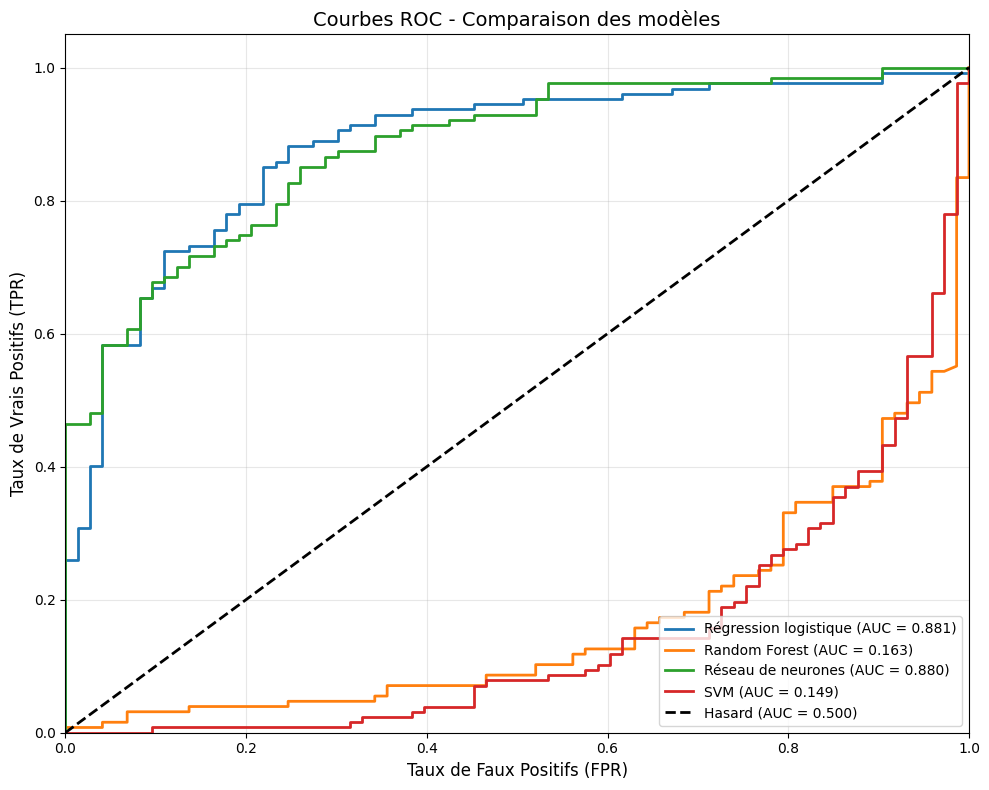

In [88]:
# Définir les modèles avec leurs noms et types d'encodage
models_info = [
    (model1, 'Régression logistique', 'binary'),      
    (model2, 'Random Forest', 'label'),               
    (model3, 'Réseau de neurones', 'binary'),
    (model4, 'SVM', 'label')
]

for model, name, _ in models_info:
    print(f"{name} classes order: {model.classes_}")

# Rendre y_test binaire 
y_test_binary = (y_test == 'objective').astype(int)

plt.figure(figsize=(10, 8))

for model, name, encoding_type in models_info:
    
    # Choisir le bon X_test selon le modèle
    if name == 'Régression logistique':
        X_test_model = X_test_scaled  
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    elif name == 'Random Forest':
        X_test_model = X_test_encoded  
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    elif name == 'Réseau de neurones':
        X_test_model = X_test_scaled  
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    elif name == 'SVM':
        X_test_model = X_test  
        y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Calculer la courbe ROC (toujours avec y_test_binary)
    fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Tracer
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Ligne diagonale
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Hasard (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Comparaison des modèles', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()